<a href="https://colab.research.google.com/github/MeepMoop/winter-school-practical/blob/main/RL_Practical_2026_Openmind_Winter_School_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2026 Openmind Winter School RL Practical
Authors: John D. Martin, Kris De Asis

Adapted from a notebook by: John D. Martin, Shruti Mishra, Jordan Hoffmann

This assignment covers a number of important reinforcement learning concepts, algorithms, and phenomena. Students will observe the general interaction between a learning system and its environment. In addition, they will implement the classic algorithms Expected Sarsa and Q-learning, for policy evaluation and control. Using experience in a small gridworld domain, students will observe how the presence of stochasticity influences step size sensitivity. The focus shifts in the latter part of the assignment to issues that arise under function approximation with a neural network. Using experience in a domain with continuous states and actions, students will observe how performance of the PPO algorithm changes with different architecture sizes.

# Environment defintion

In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import functools
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
#@title 5x5 GridWorld
class GridWorld:
  def __init__(self, stochastic=False, seed=0):
    self.stochastic = stochastic
    self.seed = seed

    self.num_rows = 5
    self.num_cols = 5
    self.num_actions = 4
    self.num_states = self.num_cols * self.num_rows

    self._rand = np.random.RandomState(self.seed)

    self._init_topology()
    self.counts = np.zeros(self.num_states)

  def _init_topology(self, initial_grid=None):
    # Assign the adjacency: [W, N, E, S]
    self.adjacency_list = np.array(
                          [[0,1,5,0],
                           [1,2,6,0],
                           [2,3,7,1],
                           [3,4,8,2],
                           [4,4,9,3],
                           [0,6,10,5],
                           [1,7,11,5],
                           [2,8,12,6],
                           [3,9,13,7],
                           [4,9,14,8],
                           [5,11,15,10],
                           [6,12,16,10],
                           [7,13,17,11],
                           [8,14,18,12],
                           [9,14,19,18],
                           [10,16,20,15],
                           [11,17,21,15],
                           [12,18,22,16],
                           [13,19,23,17],
                           [14,19,24,18],
                           [15,21,20,20],
                           [16,22,21,20],
                           [17,23,22,21],
                           [18,24,23,22],
                           [19,24,24,23]])

  def _get_obs(self):
    return jax.nn.one_hot(self.state, self.num_states)

  def _get_reward(self):
    if self.state == self.bonus_idx:
      return 1.
    return 0.

  def _get_done(self):
    if self.state == self.bonus_idx:
      return True
    return False

  def reset(self):
    self.state = 0
    self.bonus_idx = self.num_states - 1
    self.counts[self.state] += 1
    return self._get_obs()

  def step(self, action):
    if self.stochastic:
      if rs.rand() < 0.1:
        action = rs.choice(self.num_actions)
    self.state = self.adjacency_list[self.state, action]
    self.counts[self.state] += 1
    return self._get_obs(), self._get_reward(), self._get_done()

  def get_xy(self, state):
    state = state % (self.num_cols * self.num_rows)
    x = state // self.num_cols
    y = state % self.num_rows
    return x, y

  def get_state_number(self, x, y):
    return x * self.num_cols + y

  def plot(self):
    fig, ax = plt.subplots()
    grid = np.reshape(self.counts, (self.num_rows, self.num_cols))
    for i in range(self.num_rows):
      for j in range(self.num_cols):
        #  ax.text(i+.5, j+.5, str(grid[i,j]),va='center', ha='center')
        ax.text(i+.5, j+.5, str(self.get_state_number(i,j)),va='center', ha='center')
    # ax.imshow(np.flip(grid.transpose(),0),
    #           extent=[0, self.num_rows, 0, self.num_cols])
    state_numbers = np.reshape(np.arange(self.num_states), (self.num_rows, self.num_cols))
    ax.imshow(state_numbers,
              extent=[0, self.num_rows, 0, self.num_cols])
    i, j = self.get_xy(self.state)
    #ax.text(i+.5, j+.5, 'x', )

    i, j = self.get_xy(self.bonus_idx)
    #ax.text(i+.5, j+.5, '+1', va='center', ha='center')

    ax.grid(which='major', linestyle='--')


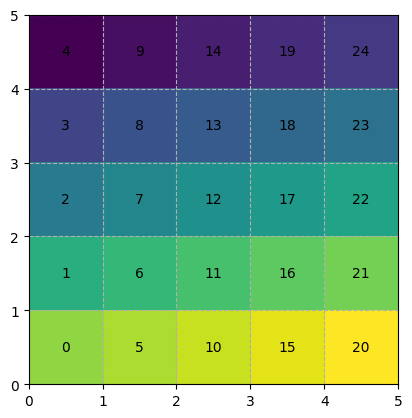

In [3]:
e = GridWorld()
e.reset()
e.plot()

In [4]:
def compute_returns(rewards, discount, bin_size=1):
    assert len(rewards) >= bin_size
    discounts = [discount**t for t in range(bin_size)]
    return np.array([np.dot(rewards[t+1:t+1+bin_size], discounts)
                     for t in range(len(rewards)-bin_size)])


def bin_vector(x, num_bins):
  j = int(len(x) / num_bins)
  return np.array([np.sum(x[i * j:(i + 1) * j]) for i in range(num_bins)])

# Part 1. Policies

In reinforcement learning a policy determines how the agent behaves. Mathematically, a policy is a mapping from states to actions $\pi : \mathcal{S} \rightarrow \mathcal{A}$. This mapping can be either deterministic or stochastic. In many cases, and particularly for the algorithms we consider, the policy is defined in terms of the value function. To familarize yourself with these ideas, you will implement several policies.

1. A uniform random policy: $a \sim \text{Uniform}(\mathcal{A})$.
2. A greedy policy that breaks ties unifomly at random. Do this for Gaussian-random values.
3. An epsilon-greedy policy that takes random actions $\varepsilon$ percent of the time. Fix $\varepsilon=0.1$ for this exercise.

After many steps of experience, the distribution of state visitation counts will be proportional to the stationary distribution of the MDP. For each policy visualize the distribution of state visitation counts using the environment attribute env.counts. How do the three policies compare?

For more information on polices and value functions see section 3.5 of Sutton and Barto. Within the same test, the greedy and epsilon-greedy policies are discussed in section 2.2.

 ## Exercise: Implement some policies.
With the provided function signatures, implement the three policies mentioned above.  

In [6]:
#@title Policies (Exercise)
def random_action(actions, rs):
  """
    actions: an np array of action indices.
    rs: the np random state.
  """
  # YOUR CODE GOES HERE.
  return rs.choice(actions)


def greedy_action(w, x, rs):
  """
    w: a (num_states, num_actions) np matrix of action values.
    x: observation vector.
    rs: the np random state.
  """
  # YOUR CODE GOES HERE.
  qs = np.matmul(x, w)
  return rs.choice(np.where(qs == np.max(qs))[0])


def epsilon_greedy(w, x, rs, epsilon=0.1):
  """
    w: a (num_states, num_actions) np matrix of action values.
    x: observation vector.
    rs: the np random state.
    epsilon: the probability of taking a random action.
  """
  # YOUR CODE GOES HERE.
  actions = np.arange(w.shape[1])
  return random_action(actions, rs) if rs.random() < epsilon else greedy_action(w, x, rs)

In [20]:
#@title Random policy (Exercise).
env = GridWorld()
last_x_w = env.reset()

rs = np.random.RandomState(0)
actions = np.arange(env.num_actions)
for _ in range(1000):
  last_action = random_action(actions, rs)
  x_w, reward, done = env.step(last_action)

  if done:
    last_x_w = env.reset()
  else:
    last_x_w = x_w
random_state_visitation = env.counts.copy()

In [21]:
#@title Greedy policy with random values (Exercise).
env = GridWorld()
last_x_w = env.reset()

rs = np.random.RandomState(0)
random_values = rs.randn(env.num_states, env.num_actions)
for _ in range(1000):
  last_action = greedy_action(random_values, last_x_w, rs)
  x_w, reward, done = env.step(last_action)

  if done:
    last_x_w = env.reset()
  else:
    last_x_w = x_w
greedy_state_visitation = env.counts.copy()

In [22]:
#@title $\varepsilon$-Greedy policy with random values (Exercise).
env = GridWorld()
last_x_w = env.reset()

rs = np.random.RandomState(0)
random_values = rs.randn(env.num_states, env.num_actions)
for _ in range(1000):
  last_action = epsilon_greedy(random_values, last_x_w, rs)
  x_w, reward, done = env.step(last_action)

  if done:
    last_x_w = env.reset()
  else:
    last_x_w = x_w
epsilon_greedy_state_visitation = env.counts.copy()

Plot the results with the code below.

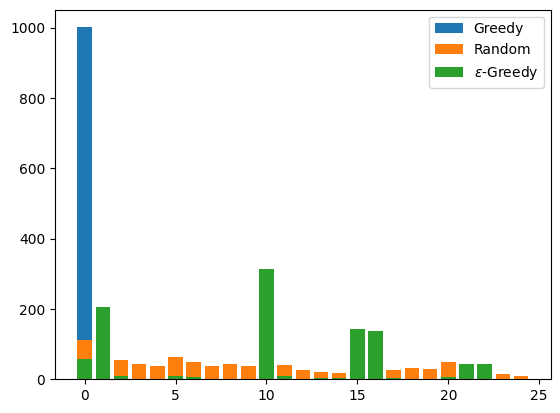

In [23]:
plt.bar(np.arange(env.num_states), greedy_state_visitation, label='Greedy')
plt.bar(np.arange(env.num_states), random_state_visitation, label='Random')
plt.bar(np.arange(env.num_states), epsilon_greedy_state_visitation, label=r'$\varepsilon$-Greedy')
plt.legend()

## Observations (Exercise)
* The greedy policy doesn't visit many states
* The random policy visits lots of states
* The $\epsilon$-greedy policy does something in between: It prefers actions that are believed to be good, while still visiting many states in case its beliefs are wrong.

# Part 2. Policy Evaluation (Prediction)

When performing policy evalution, a system learns to predict the sum of future rewards that occur while following a policy $\pi$. In this component you will implement Expected Sarsa, a learning algorithm for policy evaluation.

The Expected Sarsa algorithm starts with an arbitrary estimate of action values $Q(s,a)$, $\forall s,a$, then it uses experience gathered to incrementally improve the action-value estimates. The update rule follows the method of temporal differences at each transition $s,a\rightarrow r,s'$, where $a\sim \pi$. See section 6.6 of Sutton and Barto for more information.
$$Q(s,a) \gets Q(s,a) + \alpha[r +\gamma \sum_{a'}{\pi(a'|s')Q(s',a')} - Q(s,a)].$$


In [13]:
#@title Visualization code
def plot_colored_value_cell(x, y, q, ax, norm):
  scale = 0.2
  size = scale * 1
  cmap = cm.get_cmap('jet')#cm.Jet
  v = np.max(q)
  color=cmap(norm(v))
  head_width = .05 * scale
  head_length = .05 * scale
  x = scale * x
  y = scale * y

  rect = plt.Rectangle([x, y], size, size,
                      facecolor=color,
                      edgecolor='black',
                      clip_on=False)
  ax.add_patch(rect)

  ax.text(x+size/2, y+size/2, '{value:.2f}'.format(value=v))

  return ax

def plot_arrow_value_cell(x, y, q, ax):
  scale = 0.2
  size = scale * 1

  color='white'
  head_width = .05 * scale
  head_length = .05 * scale
  q_norm = scale * .5 * q / np.sqrt(np.sum(q**2))
  x = scale * x
  y = scale * y

  rect = plt.Rectangle([x, y], size, size,
                      facecolor=color,
                      edgecolor='black',
                      clip_on=False)
  ax.add_patch(rect)
  x = x + .5 * scale
  y = y + .5 * scale

  # left
  dx = q_norm[0]
  ax.arrow(x, y, -dx, 0,
            length_includes_head=True,
            head_width=head_width,
            head_length=head_length,
            color='black')
  # up
  dy = q_norm[1]
  ax.arrow(x, y, 0, dy,
            length_includes_head=True,
            head_width=head_width,
            head_length=head_length,
            color='black')
  # right
  dx = q_norm[2]
  ax.arrow(x, y, dx, 0,
            length_includes_head=True,
            head_width=head_width,
            head_length=head_length,
            color='black')
  #down
  dy = q_norm[3]
  ax.arrow(x, y, 0, -dy,
            length_includes_head=True,
            head_width=head_width,
            head_length=head_length,
            color='black')
  return ax

def plot_greedy_cell(x, y, q, ax):
  scale = 0.2
  size = scale * 1

  color='white'
  head_width = .05 * scale
  head_length = .05 * scale
  q_norm = scale * .5 * q / np.sqrt(np.sum(q**2))
  i_greedy = np.argmax(q_norm)

  x = scale * x
  y = scale * y

  rect = plt.Rectangle([x, y], size, size,
                      facecolor=color,
                      edgecolor='black',
                      clip_on=False)
  ax.add_patch(rect)
  x = x + .5 * scale
  y = y + .5 * scale

  if i_greedy == 0:
    # left
    dx = q_norm[0]
    ax.arrow(x, y, -dx, 0,
              length_includes_head=True,
              head_width=head_width,
              head_length=head_length,
              color='black')
  elif i_greedy == 1:
    # up
    dy = q_norm[1]
    ax.arrow(x, y, 0, dy,
              length_includes_head=True,
              head_width=head_width,
              head_length=head_length,
              color='black')
  elif i_greedy == 2:
    # right
    dx = q_norm[2]
    ax.arrow(x, y, dx, 0,
              length_includes_head=True,
              head_width=head_width,
              head_length=head_length,
              color='black')
  elif i_greedy == 3:
    #down
    dy = q_norm[3]
    ax.arrow(x, y, 0, -dy,
              length_includes_head=True,
              head_width=head_width,
              head_length=head_length,
              color='black')
  return ax


def plot_qvals(env, agent, arrow_plot=False):
  qvalues = np.zeros((env.num_states, env.num_actions))
  for s in range(env.num_states):
    state = jax.nn.one_hot(s, env.num_states)
    for a in range(env.num_actions):
      qvalues[s, a] = agent.value(state, a)

  vmin, vmax = np.min(qvalues), np.max(qvalues)
  norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)

  fig, ax = plt.subplots(figsize=(5,5))
  for i in range(25):
    x, y = env.get_xy(i)
    if arrow_plot:
      plot_arrow_value_cell(x, y, qvalues[i], ax)
    else:
      plot_colored_value_cell(x, y, qvalues[i], ax, norm)
  ax.set_axis_off()
  plt.plot()


def plot_greedy_policy(env, agent):
  qvalues = np.zeros((env.num_states, env.num_actions))
  for s in range(env.num_states):
    state = jax.nn.one_hot(s, env.num_states)
    for a in range(env.num_actions):
      qvalues[s, a] = agent.value(state, a)

  fig, ax = plt.subplots(figsize=(5,5))
  for i in range(25):
    x, y = env.get_xy(i)
    plot_greedy_cell(x, y, qvalues[i], ax)

  ax.set_axis_off()
  plt.plot()


 ## Exercise: Expected Sarsa Implementation.

 Implement the Expected Sarsa algorithm.

In [32]:
#@title Expected Sarsa (Exercise)
class ExpectedSarsa(object):
  """Expected Sarsa."""
  def __init__(self,
               first_x_w,
               num_actions,
               discount=0.9,
               alpha_w=1.):
    self.last_x_w = first_x_w
    self.num_actions = num_actions
    self.w_q = np.zeros((len(self.last_x_w), self.num_actions))
    self.discount = discount
    self.alpha_w = alpha_w

  def update(self, last_x_w, last_a, reward, x_w, done):
    # YOUR CODE GOES HERE.
    qsa = self.value(last_x_w, last_a)
    q_next = 0 if done else np.matmul(x_w, self.w_q).mean()
    td_error = reward + self.discount * q_next - qsa
    self.w_q[:, last_a] = self.w_q[:, last_a] + self.alpha_w * td_error * last_x_w

  def value(self, x_w, action):
    # YOUR CODE GOES HERE.
    return np.matmul(x_w, self.w_q)[action]

## Exercise: Policy evaluation with Expected Sarsa.

Use your implementation of Expected Sarsa to evaluate the actions of a random policy.

In [33]:
env = GridWorld()
last_x_w = env.reset()
agent = ExpectedSarsa(first_x_w=last_x_w, num_actions=env.num_actions)

rs = np.random.RandomState(0)
actions = np.arange(env.num_actions)
steps = []
ep_steps = 0.
for t in range(1000):
  last_action = random_action(actions, rs)
  x_w, reward, done = env.step(last_action)
  agent.update(last_x_w, last_action, reward, x_w, done)

  ep_steps += 1
  if done:
    last_x_w = env.reset()
    steps.append(ep_steps)
    ep_steps = 0.
  else:
    last_x_w = x_w

/tmp/ipython-input-4116031424.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')#cm.Jet


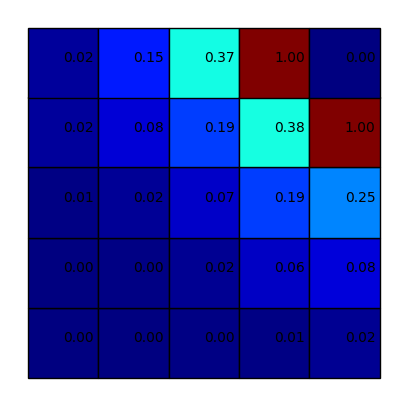

In [34]:
plot_qvals(env, agent)

# Part 3. Value-iteration (Control)

Reinforcement learning is renowed for having general-purpose algorithms that can learn useful policies without access to a transition model. Algorithms of this type sample transitions by directly interacting with an environment: taking actions and observing the outcomes. With this feedback, a learning system can iteratively evaluate and improve its policy, so that in the long term, its actions lead to the maximum amount of future reward.

Here we focus on an off-policy algorithm for control. Off-policy algorithms use experience gathered under a behavior policy, $\pi$, to update a target policy $\pi^*$. The Q-learning algorithm (Watkins, 1989) considers the greedy target policy and applies the method of temporal differences to update its action-value estimates. The update rule is given below.

$$Q(s,a) \gets Q(s,a) + \alpha[r+\gamma \max_{a'\in\mathcal{A}} Q(s',a') - Q(s,a)].$$



 ## Exercise: Q-learning implementation

Implement Q-learning

In [35]:
#@title Q-learning (Exercise)
class QLearning(object):
  """QLearning."""
  def __init__(self,
               first_x_w,
               num_actions,
               discount=0.9,
               alpha_w=1.):
    self.last_x_w = first_x_w
    self.num_actions = num_actions
    self.w_q = np.zeros((len(self.last_x_w), self.num_actions))
    self.discount = discount
    self.alpha_w= alpha_w

  def update(self, last_x_w, last_a, reward, x_w, done):
    # YOUR CODE GOES HERE.
    qsa = self.value(last_x_w, last_a)
    q_next = 0 if done else np.matmul(x_w, self.w_q).max()
    td_error = reward + self.discount * q_next - qsa
    self.w_q[:, last_a] = self.w_q[:, last_a] + self.alpha_w * td_error * last_x_w

  def value(self, x_w, action):
    # YOUR CODE GOES HERE.
    return np.matmul(x_w, self.w_q)[action]

In [36]:
env = GridWorld()
last_x_w = env.reset()
agent = QLearning(first_x_w=last_x_w, num_actions=env.num_actions)

rs = np.random.RandomState(0)
steps = []
ep_steps = 0.
for t in range(1000):
  last_action = epsilon_greedy(agent.w_q, last_x_w, rs)
  x_w, reward, done = env.step(last_action)
  agent.update(last_x_w, last_action, reward, x_w, done)

  ep_steps += 1
  if done:
    last_x_w = env.reset()
    steps.append(ep_steps)
    ep_steps = 0.
  else:
    last_x_w = x_w

/tmp/ipython-input-4116031424.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')#cm.Jet


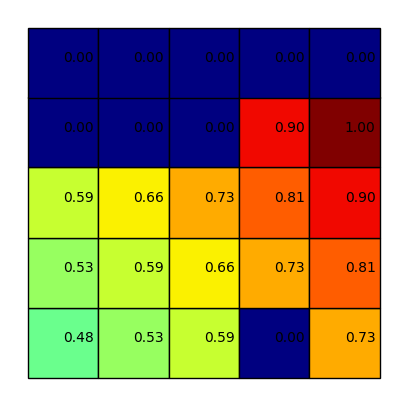

In [37]:
plot_qvals(env, agent)

/tmp/ipython-input-4116031424.py:79: RuntimeWarning: invalid value encountered in divide
  q_norm = scale * .5 * q / np.sqrt(np.sum(q**2))


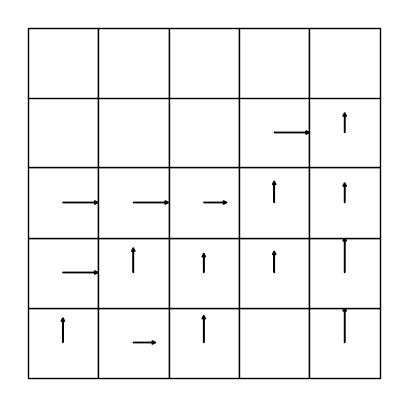

In [38]:
plot_greedy_policy(env, agent)

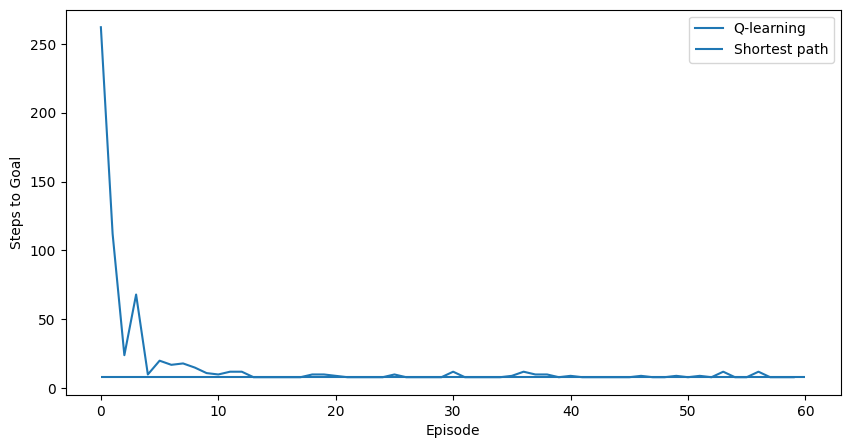

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(len(steps)), steps, label='Q-learning')
ax.hlines(y=8, xmin=0, xmax=len(steps), label='Shortest path')
ax.set_xlabel('Episode')
ax.set_ylabel('Steps to Goal')
ax.legend()

 ## Exercise: Exploration parameter sensitivity.

The parameter $\varepsilon$ is said to control the amount of exploration the learning system experiences. In this context, $\varepsilon$ specifically controls the probability of taking an action uniformly at random.

In this exercise, we would like to tune the exploration parameter to acheive better learning performance. Choose an aggregate performance metric, such as the average number of steps to the goal, then evaluate the metric for several different values of $\varepsilon$, e.g. $\varepsilon \in \{0, 0.1, 0.2, 0.3, \cdots, 1\}$. What value of $\varepsilon$ achieved the best aggregate performance? Construct a sensitivy curve by plotting $\varepsilon$ versus aggregate performance. Comment on the profile of the curve; explain the behavior at the extreme values. Do you believe that further improvements would be possible with a different evaluation?

Text(0, 0.5, 'Avg. Episode Length')

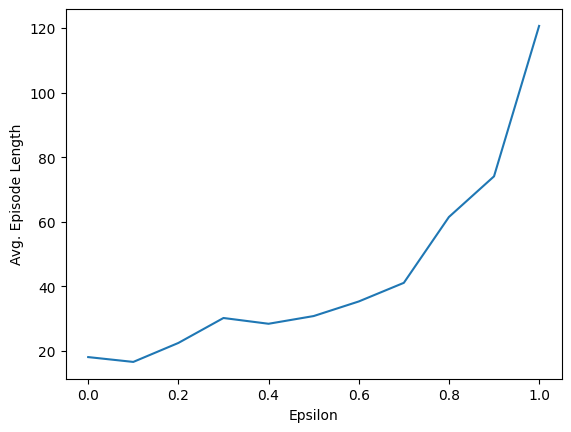

In [42]:
#@title Exercise

# YOUR CODE GOES HERE.
epsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results = []

for epsilon in epsilons:
  env = GridWorld()
  last_x_w = env.reset()
  agent = QLearning(first_x_w=last_x_w, num_actions=env.num_actions)

  rs = np.random.RandomState(0)
  steps = []
  ep_steps = 0.
  for t in range(1000):
    last_action = epsilon_greedy(agent.w_q, last_x_w, rs, epsilon)
    x_w, reward, done = env.step(last_action)
    agent.update(last_x_w, last_action, reward, x_w, done)

    ep_steps += 1
    if done:
      last_x_w = env.reset()
      steps.append(ep_steps)
      ep_steps = 0.
    else:
      last_x_w = x_w

  results.append(np.mean(steps))

plt.plot(epsilons, results)
plt.xlabel("Epsilon")
plt.ylabel("Avg. Episode Length")
plt.show()

 ## Exercise: Step-size sensitivity.
The stepsize $\alpha$ controls the size of the learning system's corrections. This can have a significant effect on the system's overall adaptibility: its rate of learning and its longterm stability.

In this exercise we would like you to fix the exploration parameter to $\varepsilon =0.1$ and repeat the previous sensitivity analysis for the step size. Using the step size in place of the exploration parameter, use the same aggregate performance metric to evaluate several different values of $\alpha$. For example, make sure your evaluation range captures the extreme cases of $\alpha=0$ and $\alpha=1$, e.g. $\alpha\in\{0,10^{-3}, 10^{-2}, 10^{-1}, 1\}$. Which value of $\alpha$ demonstrated the highest aggregate performance?


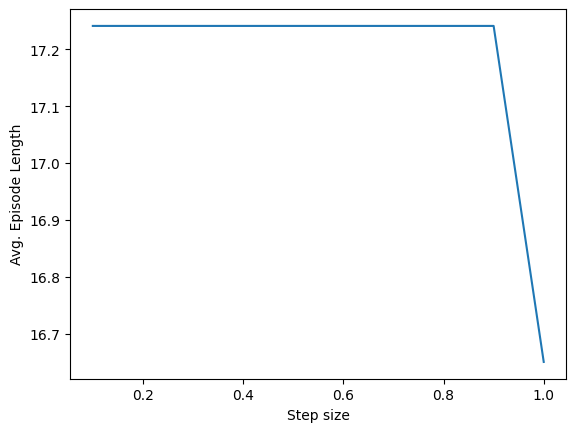

In [47]:
#@title Exercise

# YOUR CODE GOES HERE.
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
results = []

for alpha in alphas:
  env = GridWorld()
  last_x_w = env.reset()
  agent = QLearning(first_x_w=last_x_w, num_actions=env.num_actions, alpha_w=alpha)

  rs = np.random.RandomState(0)
  steps = []
  ep_steps = 0.
  for t in range(1000):
    last_action = epsilon_greedy(agent.w_q, last_x_w, rs)
    x_w, reward, done = env.step(last_action)
    agent.update(last_x_w, last_action, reward, x_w, done)

    ep_steps += 1
    if done:
      last_x_w = env.reset()
      steps.append(ep_steps)
      ep_steps = 0.
    else:
      last_x_w = x_w

  results.append(np.mean(steps))

plt.plot(alphas, results)
plt.xlabel("Step size")
plt.ylabel("Avg. Episode Length")
plt.show()

## Exercise: Stochastic transitions.
The previous exercises took place in a deterministic environment. In reality, most environments are stochastic, and these are also some of the most interesting application domains of RL.

Point out the differences from the previously studeied phenomena. This should have been observed in your results from the previous two exercises. Repeat the above analysis for the stochastic domain. How did the results change?

Now that the domain is stochastic, it does not suffice to look at the performance of just a single trial. Run 30 trials with different seeds and plot the average performance as well as the standard error confidence intervals.

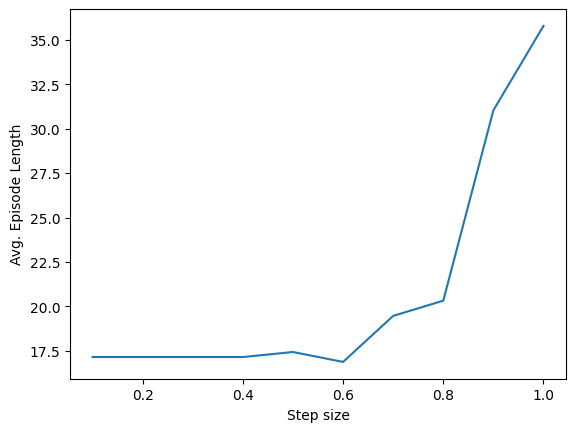

In [48]:
#@title Exercise

# YOUR CODE GOES HERE.
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
results = []

for alpha in alphas:
  env = GridWorld(stochastic=True)
  last_x_w = env.reset()
  agent = QLearning(first_x_w=last_x_w, num_actions=env.num_actions, alpha_w=alpha)

  rs = np.random.RandomState(0)
  steps = []
  ep_steps = 0.
  for t in range(1000):
    last_action = epsilon_greedy(agent.w_q, last_x_w, rs)
    x_w, reward, done = env.step(last_action)
    agent.update(last_x_w, last_action, reward, x_w, done)

    ep_steps += 1
    if done:
      last_x_w = env.reset()
      steps.append(ep_steps)
      ep_steps = 0.
    else:
      last_x_w = x_w

  results.append(np.mean(steps))

plt.plot(alphas, results)
plt.xlabel("Step size")
plt.ylabel("Avg. Episode Length")
plt.show()

Use the code below to plot learning performance.

In [57]:
alpha_w = 0.5
epsilon = 0.1

env = GridWorld(stochastic=True)

trial_steps = []
for seed in range(30):
  rs = np.random.RandomState(seed)
  steps = []; ep_steps = 0.
  last_x_w = env.reset()
  agent = QLearning(first_x_w=last_x_w,
                    num_actions=env.num_actions,
                    alpha_w=alpha_w)
  # loop over episodes instead of steps
  for ep in range(50):
    while True:
      last_action = epsilon_greedy(agent.w_q, last_x_w, rs, epsilon=epsilon)
      x_w, reward, done = env.step(last_action)
      agent.update(last_x_w, last_action, reward, x_w, done)

      ep_steps += 1
      if done:
        last_x_w = env.reset()
        steps.append(ep_steps)
        ep_steps = 0.
        break
      else:
        last_x_w = x_w
  trial_steps.append(np.array(steps))

In [58]:
def mean_confidence_interval(data):
    import scipy as sp
    """Compute confidence interval from sample data."""
    num_samp = len(data)
    mean = np.array(np.mean(data, axis=0))
    se = sp.stats.sem(data, axis=0)
    return mean, se

<ErrorbarContainer object of 3 artists>

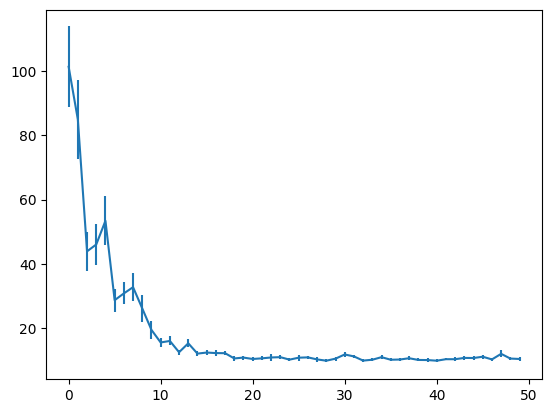

In [59]:
data = np.array(trial_steps)
mean_steps, se = mean_confidence_interval(data)
plt.errorbar(np.arange(len(mean_steps)), mean_steps, yerr=se)

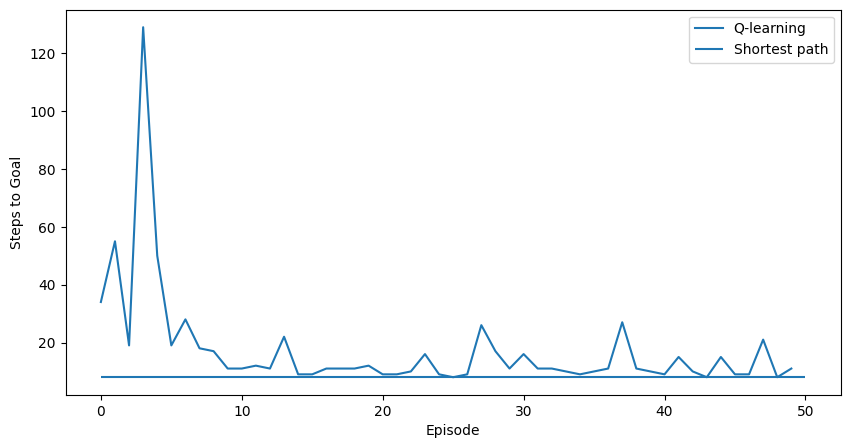

In [60]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(len(steps)), steps, label='Q-learning')
ax.hlines(y=8, xmin=0, xmax=len(steps), label='Shortest path')
ax.set_xlabel('Episode')
ax.set_ylabel('Steps to Goal')
ax.legend()

# Part 4. Continuous control with PPO.

This next part with guide you through a control problem using the PPO algorithm from the [Stable Baselines repository](https://github.com/hill-a/stable-baselines).

The code is adapted from the [Stable Baselines tutorial](https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/master/stable_baselines_getting_started.ipynb).


## Introduction

In this notebook, you will learn how to create a RL model, train it and evaluate it.


## Install Dependencies and Stable Baselines Using Pip

List of full dependencies can be found in the [README](https://github.com/hill-a/stable-baselines).

```
sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev
```


```
pip install stable-baselines[mpi]
```

In [ ]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines[mpi]==2.10.2
from IPython.display import clear_output
clear_output()

In [ ]:
import stable_baselines
stable_baselines.__version__

Stable-Baselines works on environments that follow the [gym interface](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html).
You can find a list of available environments [here](https://gym.openai.com/envs/#classic_control).

It is also recommended to check the [source code](https://github.com/openai/gym) to learn more about the observation and action space of each env, as gym does not have a proper documentation.
Not all algorithms can work with all action spaces, you can find more in this [recap table](https://stable-baselines.readthedocs.io/en/master/guide/algos.html).

## Imports

In [ ]:
import gym
import numpy as np
from stable_baselines import PPO2

You need to import the policy class that will be used to create the networks (for the policy/value functions).
This step is optional as you can directly use strings in the constructor:

```PPO2('MlpPolicy', env)``` instead of ```PPO2(MlpPolicy, env)```

Note that some algorithms like `SAC` have their own `MlpPolicy` (different from `stable_baselines.common.policies.MlPolicy`), that's why using string for the policy is the recommened option.

In [ ]:
from stable_baselines.common.policies import MlpPolicy

## Create the Gym env and instantiate the agent

For this example, we will use CartPole environment, a classic control problem.

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright.

Cartpole environment: [https://gym.openai.com/envs/CartPole-v1/](https://gym.openai.com/envs/CartPole-v1/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)

Note: vectorized environments allow to easily multiprocess training. In this example, we are using only one process, hence the `DummyVecEnv`.

We chose the `MlpPolicy` because input of `CartPole` is a feature vector, not images.

The type of action to use (discrete/continuous) will be automatically deduced from the environment action space


Here we are using the [Proximal Policy Optimization](https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html) algorithm (PPO2 is the version optimized for GPU), which is an Actor-Critic method: it uses a value function to improve the policy gradient descent (by reducing the variance).

It combines ideas from [A2C](https://stable-baselines.readthedocs.io/en/master/modules/a2c.html) (having multiple workers and using an entropy bonus for exploration) and [TRPO](https://stable-baselines.readthedocs.io/en/master/modules/trpo.html) (it uses a trust region to improve stability and avoid catastrophic drops in performance).

PPO is an on-policy algorithm, which means that the trajectories used to update the networks must be collected using the latest policy.
It is usually less sample efficient than off-policy alorithms like [DQN](https://stable-baselines.readthedocs.io/en/master/modules/dqn.html), [SAC](https://stable-baselines.readthedocs.io/en/master/modules/sac.html) or [TD3](https://stable-baselines.readthedocs.io/en/master/modules/td3.html), but is much faster regarding wall-clock time.


## Exercise: Sweeps of architecture size and step size.

> `verbose=1` prints the output as the model learns

> `learning_rate`: (float or callable) The step size, it can be a function. See
https://github.com/hill-a/stable-baselines/blob/master/stable_baselines/ppo2/ppo2.py
for further details.

> `net_arch`: parameter allows to specify the amount and size of the hidden layers
and how many of them are shared between the policy network and the value
network. See
https://github.com/hill-a/stable-baselines/blob/master/stable_baselines/common/policies.py
for further details.

**Adjust the step size and architecture** and observe the differences in learning performance.

In [ ]:
env = gym.make('CartPole-v1')

# vectorized environments allow to easily multiprocess training
# we demonstrate its usefulness in the next examples
# env = DummyVecEnv([lambda: env])

# model = PPO2(MlpPolicy, env, verbose=0)
model = PPO2(MlpPolicy, env, verbose=0,
             learning_rate=2.5e-4,
             policy_kwargs=dict(net_arch=[64, 64]))
# clear_output()

In [ ]:
print(env)

We create a helper function to evaluate the agent:

In [ ]:
def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

In fact, Stable-Baselines already provides you with that helper:

In [ ]:
from stable_baselines.common.evaluation import evaluate_policy

Let's evaluate the un-trained agent, this should be a random agent.

In [ ]:
# Use a separate environment for evaluation
eval_env = gym.make('CartPole-v1')

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

## Train the agent and evaluate it

In [ ]:
# Train the agent for 10000 steps
model.learn(total_timesteps=10000)

In [ ]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

The `mean_reward` above is quite low for this task. Your challenge in this exercise is:

## Exercise: Try and adjust the parameters above to get the highest possible mean reward.
* What parameter combinations worked well?
* What does the performance do as you keep changing a parameter in one direction? For example, try running with:
`learning_rate: 1e-6, 1e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1`.
* Try changing the `arch` to be more/less powerful. How does this impact performance? Does it saturate? You can try using the colab magic `%%timeit` to see the impact on training speed.

## `STOP HERE`
If, after the session, you want to try and visualise the models, you can try and run the code below.

## Prepare video recording

**Note:** This will _NOT_ work on a Google Colaboratory. If you run this locally, you can try and get this working.

In [ ]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper.

In [ ]:
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make('CartPole-v1')])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

### Visualize trained agent



In [ ]:
record_video('CartPole-v1', model, video_length=500, prefix='ppo2-cartpole')

In [ ]:
show_videos('videos', prefix='ppo2')

# Want to learn more?

Many of these references were originally compiled by Feryal Behbahani and Gheorghe Comanici [[here](https://colab.research.google.com/github/eemlcommunity/PracticalSessions2020/blob/master/rl/EEML2020_RL_Tutorial.ipynb#scrollTo=XWqlIWbwN7Mk)].

Books and lecture notes
*   [Reinforcement Learning: an Introduction by Sutton & Barto](http://incompleteideas.net/book/RLbook2018.pdf)
* [Algorithms for Reinforcement Learning by Csaba Szepesvari](https://sites.ualberta.ca/~szepesva/papers/RLAlgsInMDPs.pdf)

Lectures and course
*   [Reinforcement learning course at UCL by David Silver](https://www.youtube.com/playlist?list=PLzuuYNsE1EZAXYR4FJ75jcJseBmo4KQ9-)
*   [Reinforcement learning course by UCL & DeepMind](https://www.youtube.com/playlist?list=PLqYmG7hTraZBKeNJ-JE_eyJHZ7XgBoAyb)
*   [Reinforcement learning course at Stanford by Emma Brunskill](https://www.youtube.com/playlist?list=PLoROMvodv4rOSOPzutgyCTapiGlY2Nd8u)
*   [Reinforcement learning course on U Alberta Coursera by Martha White & Adam White](https://www.coursera.org/specializations/reinforcement-learning)
*   [Reinforcement learning lecture at NPTEL by Balaraman Ravindran](https://youtu.be/YaPSPu7K9S0)

More practical:
* [Spinning Up in Deep RL by Josh Achiam](https://spinningup.openai.com/en/latest/)
* [An interactive tutorial on TD learning by Andrej Karpathy](https://cs.stanford.edu/people/karpathy/reinforcejs/gridworld_td.html)


